# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.340347,True,7.340040
1,0.470065,True,4.349850
2,-2.659587,False,-1.341256
3,0.846692,True,5.157265
4,1.683904,True,6.505777
...,...,...,...
995,-1.333868,False,-3.289519
996,0.339126,True,4.310804
997,0.050584,False,-0.497140
998,-1.041022,True,5.122790


<AxesSubplot: xlabel='v0'>

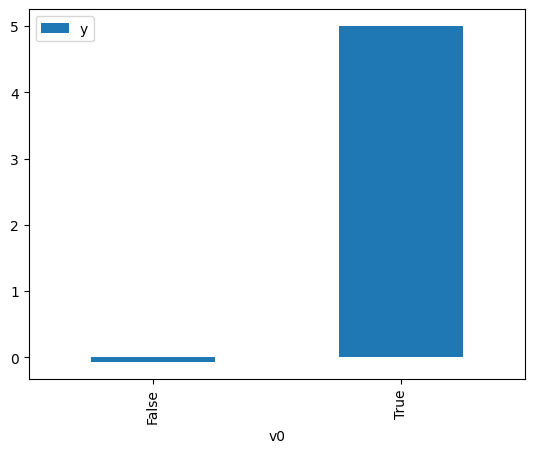

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

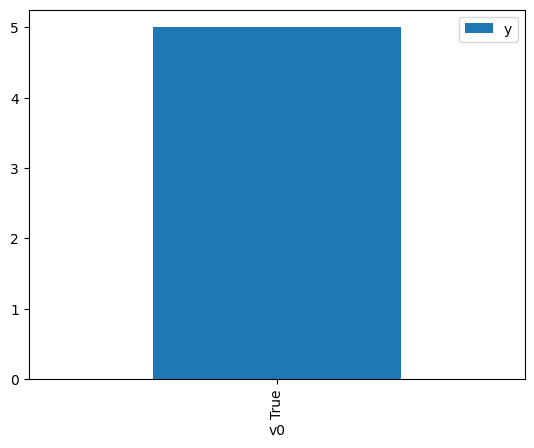

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.821278,False,0.596769,0.797211,1.254373
1,-1.354589,False,-1.594754,0.907381,1.102073
2,1.319625,False,1.547649,0.091405,10.940379
3,-0.537935,False,0.405684,0.707615,1.413199
4,1.206744,False,1.113985,0.108773,9.193447
...,...,...,...,...,...
995,1.145705,False,1.585617,0.119326,8.380385
996,-0.668000,False,0.489214,0.751479,1.330709
997,1.067029,False,-0.245642,0.134224,7.450260
998,-0.765090,False,-0.220631,0.781213,1.280060


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.257210,True,2.978846,0.400548,2.496578
1,-1.912557,True,3.713601,0.037783,26.467203
2,-0.255877,True,4.387382,0.401096,2.493166
3,-0.634019,True,4.885143,0.259545,3.852900
4,1.471088,True,4.915131,0.927971,1.077620
...,...,...,...,...,...
995,1.092960,True,6.565234,0.870853,1.148300
996,0.254600,True,4.614615,0.616121,1.623057
997,0.148020,True,6.168556,0.572152,1.747789
998,-0.248342,True,5.765298,0.404200,2.474026


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              6672.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:02:12   Log-Likelihood:                         -1390.7
No. Observations:                1000   AIC:                                      2785.
Df Residuals:                     998   BIC:                                      2795.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5089      0.032     15.977      0.000       0.446       0.571
x2             5.0412      0.048    105.402      0.000       4.947       5.135
==============================================================================
Omnibus:                        0.752   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.623
Skew:                           0.002   Prob(JB):                        0.732
Kurtosis:                       3.122   Cond. No.                         1.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""